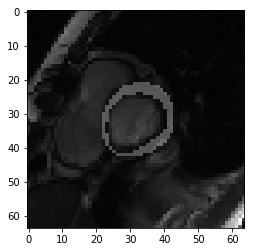

In [41]:
%matplotlib inline
import torch, torch.nn as nn, torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
from scipy.ndimage import zoom

data=np.load('scd_lvsegs_cropped.npz') # load all the data from the archive

images=data['images'] # images in BHW array order
segs=data['segs'] # segmentations in BHW array order
caseIndices=data['caseIndices'] # the indices in `images` for each case

images=images.astype(np.float32)/images.max() # normalize images

images=zoom(images,(1,0.5,0.5))
segs=(zoom(segs,(1,0.5,0.5))>0).astype(np.int32)

plt.imshow(images[13]+segs[13]*0.25,cmap='gray')

In [42]:
testIndex=caseIndices[-6,0] # keep the last 6 cases for testing

# divide the images, segmentations, and categories into train/test sets
trainImages,trainSegs=images[:testIndex],segs[:testIndex]
testImages,testSegs=images[testIndex:],segs[testIndex:]

In [6]:
class DiceLoss(nn.modules.loss._Loss):
    '''This defines the binary dice loss function used to assess segmentation overlap.'''
    def forward(self, source, target, smooth=1e-5):
        batchsize = target.size(0)
        source=source.sigmoid() # apply sigmoid to the source logits to impose it onto the [0,1] interval
        
        # flatten target and source arrays to 2D BV arrays
        tsum=target.view(batchsize, -1) 
        psum=source.view(batchsize, -1)
        
        intersection=psum*tsum
        sums=psum+tsum 

        # compute the score, the `smooth` value is used to smooth results and prevent divide-by-zero
        score = 2.0 * (intersection.sum(1) + smooth) / (sums.sum(1) + smooth)
        
        # `score` is 1 for perfectly identical source and target, 0 for entirely disjoint
        return 1 - score.sum() / batchsize

In [8]:
class UnetBlock(nn.Module):
    def __init__(self,inChannels,outChannels,subblock):
        super().__init__()
        self.encode=nn.Conv2d(inChannels,outChannels,3,2,1)
        self.eBN=nn.BatchNorm2d(outChannels)
        self.eDrop=nn.Dropout2d(0.5)
        
        self.decode=nn.ConvTranspose2d(outChannels*2,inChannels,3,2,1,1)
        self.dBN=nn.BatchNorm2d(inChannels)
        self.dDrop=nn.Dropout2d(0.5)
        
        self.subblock=subblock
        
    def forward(self,x):
        #encode stage
        enc=self.encode(x)
        enc=self.eBN(enc)
        enc=self.eDrop(enc)
        enc=torch.relu(enc)
        
        # pass through subblock and concat
        sub=self.subblock(enc)
        sub=torch.cat([enc,sub],1)
        
        #decode stage
        dec=self.decode(sub)
        dec=self.dBN(dec)
        dec=self.dDrop(dec)
        dec=torch.relu(dec)
        
        return dec
    

class UNet(nn.Sequential):
    def __init__(self):
        # bottom subblock
        net=nn.Sequential(
            nn.Conv2d(64,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # build the unet structure from the bottom up
        net=UnetBlock(32,64,net)
        net=UnetBlock(16,32,net)
        net=UnetBlock(8,16,net)
        net=UnetBlock(4,8,net)

        # final top-level structure omits dropout and applies sigmoid to the output
        super().__init__(
            nn.Conv2d(1,4,3,1,1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            net,
            nn.Conv2d(4,1,3,1,1),
        )

In [37]:
class SegNet(nn.Sequential):
    def __init__(self):
        super().__init__(
            # layer 1: convolution, normalization, downsampling
            nn.Conv2d(1,4,3,1,1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1),
            # layer 2
            nn.Conv2d(4,8,3,1,1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
#             nn.MaxPool2d(3,2,1),
#             # layer 3: just convolution and normalization
#             nn.Conv2d(8,16,3,1,1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             # layer 4: convolution, normalization, upsample using transpose conv
#             nn.ConvTranspose2d(16,8,3,2,1,1),
#             nn.BatchNorm2d(8),
#             nn.ReLU(),
            # layer 5
            nn.ConvTranspose2d(8,4,3,2,1,1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            # layer 6: output
            nn.Conv2d(4,1,3,1,1),
        )
        
n=torch.rand((1,1,16,16))
SegNet()(n).shape

torch.Size([1, 1, 16, 16])

50 0.739101767539978
100 0.5695204734802246
150 0.5288498401641846
200 0.5012894868850708
250 0.48508113622665405
300 0.47521311044692993
350 0.46705496311187744
400 0.46203190088272095
450 0.45728838443756104
500 0.4542936682701111
550 0.45042526721954346
600 0.44766610860824585
650 0.4432963728904724
700 0.4408760666847229
750 0.437258780002594
800 0.43290358781814575
850 0.4305930733680725
900 0.4301254153251648
950 0.4286321997642517
1000 0.4255496859550476
CPU times: user 32.2 s, sys: 9.6 s, total: 41.8 s
Wall time: 41.8 s


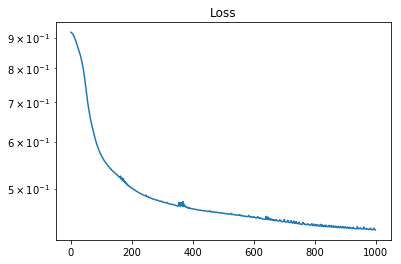

In [38]:
%%time
# store the training data as tensors
trainTensor=torch.from_numpy(trainImages[:,None])
segTensor=torch.from_numpy(trainSegs[:,None].astype(np.float32))

# create network object
net=SegNet()

# choose a device and move the net and tensors to its memory
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net=net.to(device)
trainTensor=trainTensor.to(device)
segTensor=segTensor.to(device)

# define optimizer and loss function
opt=torch.optim.Adam(net.parameters(),0.005)
loss=DiceLoss()

trainSteps=1000
losses=[]

# run through training steps
for t in range(1,trainSteps+1):
    opt.zero_grad()
    net.train()
    pred=net(trainTensor)
    lossval=loss(pred,segTensor)
    lossval.backward()
    opt.step()
        
    losses.append(lossval.item())
    if t%(trainSteps//20)==0:
        print(t,lossval.item())
        
# state=net.state_dict()
# torch.save(state,'lvsegmentmodel.pth')    
    
plt.title('Loss')
plt.semilogy(losses)

# # instead of training, load the pre-trained model to save time
# state=torch.load('lvsegmentmodel.pth')
# net.load_state_dict(state)

Test loss: 0.9346106052398682


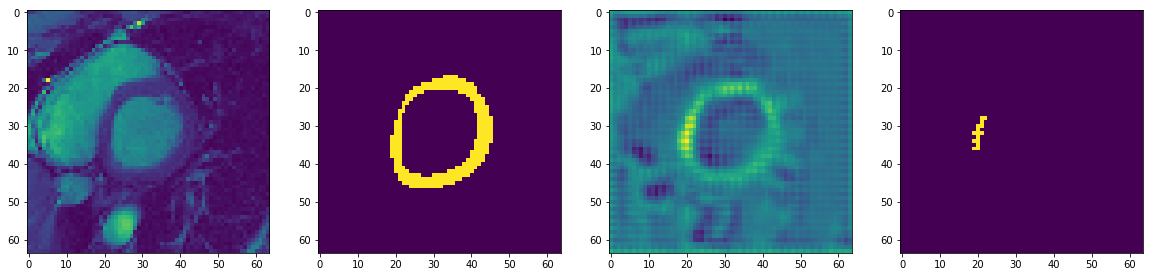

In [39]:
# device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss=DiceLoss()

testTensor=torch.from_numpy(testImages[:,None]).to(device)
testSegTensor=torch.from_numpy(testSegs[:,None]).to(device).float()

net.to(device)
net.eval()
pred=net(testTensor)
testloss=loss(pred,testSegTensor).item() # calculate test loss

pred=pred.to('cpu').data.numpy()

seg=pred>0.5

fig,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(testImages[10])
ax[1].imshow(testSegs[10])
ax[2].imshow(pred[10,0])
ax[3].imshow(seg[10,0])

print('Test loss:',testloss)